In [2]:
import pandas as pd
import os
import sklearn
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# for split data
from sklearn.model_selection import train_test_split
# for decision tree
import xgboost
from xgboost import XGBClassifier
# for evaluation
from sklearn.metrics import confusion_matrix
# for tensorflow
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('/kaggle/input/telecom-customer/Telecom_customer churn.csv')

# 1 | Understand and Preprocess the data

In [5]:
df.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,...,0.0,I,U,U,U,U,U,Y,434.0,1000005


In [6]:
df.shape

(100000, 100)

## Lets check for the Null value

Text(0.5, 1.0, 'Distribution of number of missing feature of each customer')

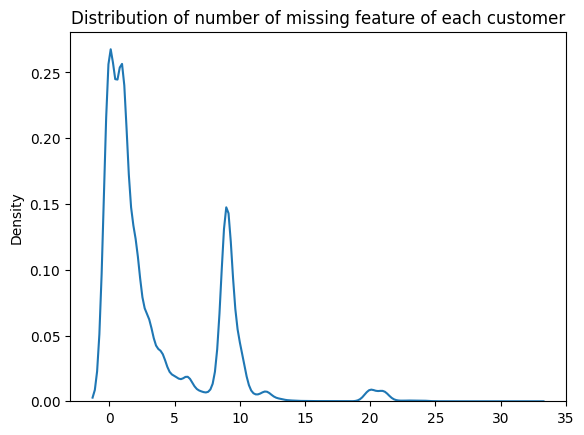

In [7]:
sns.kdeplot(df.isna().sum(axis=1))
plt.gca().set_title('Distribution of number of missing feature of each customer')

> Base on the distribution above, the number of missing feature of each customer is quite small. <br>
> There are 100 columns, but the majority of these customers is only missing <= 10 columns. <br>
> However, to make the model more robust, we will exclude all customers that have more than 5 missing columns. <br>
> We will fill other columns with the average or mode value of those columns.

In [8]:
df_nnull = df[df.isna().sum(axis=1) < 5]
print(
    f"""
    If excluding customers with more than 5 missing columns, the remaining number of observation is 
    {(df_nnull.shape[0] / df.shape[0])*100} %
    of the original data
    """
)



    If excluding customers with more than 5 missing columns, the remaining number of observation is 
    72.396 %
    of the original data
    


**Lets replace null value in the residual dataframe with the average or mode of each column.**

In [9]:
# Determine the data type of each column (numeric or categorical)
numeric_cols = df_nnull.select_dtypes(include='number').columns
categorical_cols = df_nnull.select_dtypes(exclude='number').columns

In [10]:
df_nnull[categorical_cols] = df_nnull[categorical_cols].fillna(df_nnull[categorical_cols].mode().iloc[0])
df_nnull[numeric_cols] = df_nnull[numeric_cols].fillna(df[numeric_cols].mean())

/tmp/ipykernel_28/1965959571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nnull[categorical_cols] = df_nnull[categorical_cols].fillna(df_nnull[categorical_cols].mode().iloc[0])
/tmp/ipykernel_28/1965959571.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nnull[numeric_cols] = df_nnull[numeric_cols].fillna(df[numeric_cols].mean())


In [11]:
print(
    f"""
    The total number of null values left is
    {df_nnull.isna().sum().sum()}
    """
)


    The total number of null values left is
    0
    


**Lets see the distribution of churn customers**

([<matplotlib.patches.Wedge at 0x7f14585f8490>,
 [Text(-0.015135673311449674, 1.099895863885945, '0'),
  Text(0.015135673311449539, -1.099895863885945, '1')],
 [Text(-0.008255821806245275, 0.5999431984832426, '50.4%'),
  Text(0.008255821806245203, -0.5999431984832426, '49.6%')])

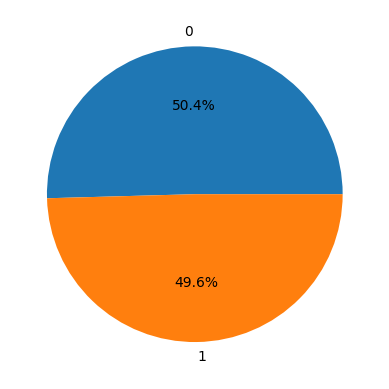

In [12]:
data = df.churn.value_counts()

plt.pie(
    data = data,
    x = data.values,
    labels = data.index,
    autopct='%1.1f%%'
)

> The target's distribution is quite unified

# 2 | DECISION TREE

**Before get the dummies variables from this data, lets first look at the number of distinct value in each column.**

In [13]:
index_list = []
val_list = []
for col in categorical_cols:
    index_list.append(col)
    val_list.append(len(df_nnull[categorical_cols][col].unique()))
unique_count_ser = pd.Series(val_list,index= index_list).sort_values()
print("Number of distinct options in each categorical column: ")
print(unique_count_ser)

Number of distinct options in each categorical column: 
infobase             1
creditcd             2
kid11_15             2
asl_flag             2
kid6_10              2
kid3_5               2
kid0_2               2
refurb_new           2
ownrent              2
dwlltype             2
kid16_17             2
new_cell             3
hnd_webcap           3
dualband             4
prizm_social_one     5
marital              5
HHstatin             6
dwllsize            15
ethnic              17
area                19
crclscod            51
dtype: int64


* 'crclscod': Credit score
* 'area': Area of living
* 'ethnic': Customer's ethnic
* 'dwllsize': Dwelling size

**These variables are important, so we can not exclude them.** <br>
The only column we can get rid of is the CustomerID column

In [14]:
df_nnull = df_nnull.drop('Customer_ID',axis=1)

Get dummy variable

In [15]:
df_dum = pd.get_dummies(df_nnull)

In [16]:
df_dum.shape

(72396, 227)

In [17]:
x = df_dum.drop('churn',axis=1)
y = df_dum[['churn']]
# Split data
x_train, x_valid, y_train, y_valid = train_test_split(x, y,test_size = 0.2)

In [18]:
model_xgb = XGBClassifier()

In [19]:
model_xgb.fit(x_train, y_train, verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
def calculate_perform_metrics(total_confusion_matrix):
    # get components
    TP = total_confusion_matrix[1,1]
    TN = total_confusion_matrix[0,0]
    FP = total_confusion_matrix[0,1]
    FN = total_confusion_matrix[1,0]
    # calculate metrics
    metric_dict ={
        'accuracy': (TP+TN)/(TP+TN+FP+FN),
        'precision': TP/(TP+FP),
        'recall': TP/(TP+FN),
        'F1': 2 * (TP/(TP+FP) * TP/(TP+FN)) / (TP/(TP+FP) + TP/(TP+FN)) #  2 * (precision * recall) / (precision + recall)
    }
    
    return metric_dict

In [22]:
def labeling_evaluating(y_true, y_pred, threshold):
    y_pred[y_pred > threshold] = 1
    y_pred[y_pred <= threshold] = 0
    cm = confusion_matrix(y_true, y_pred)    
    # calcualte metric dict 
    metric_dict = calculate_perform_metrics(cm)
    return metric_dict, cm

{'accuracy': 0.6319751381215469, 'precision': 0.6263956484397366, 'recall': 0.6167723749119098, 'F1': 0.621546765144521}


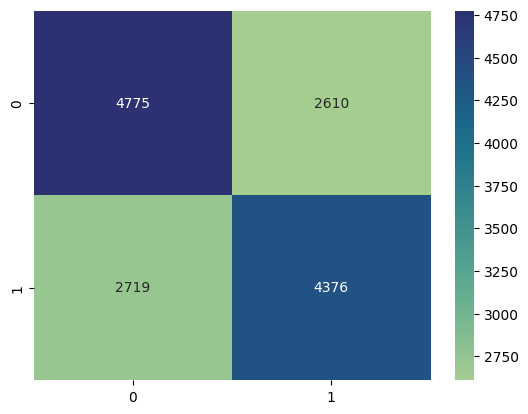

In [24]:
y_pred = model_xgb.predict(x_valid)
metric_dict, cm = labeling_evaluating(y_valid, y_pred, threshold = 0.5)
sns.heatmap(cm, annot=True, cmap="crest", fmt='.4g')
print(metric_dict)

# 3 | Lets try neural network

In [53]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 150),
    tf.keras.layers.Dense(units = 100),
    tf.keras.layers.Dense(units = 50),
    tf.keras.layers.Dense(units = 20),
    tf.keras.layers.Dense(units = 1, activation='sigmoid'),
])

In [54]:
model_tf.compile(
    loss= 'BinaryCrossentropy',
    optimizer= 'Adam',
    metrics = ['accuracy']
)

In [55]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_valid = x_valid.astype('float32')
y_valid = y_valid.astype('float32')

In [56]:
model_tf.fit(
    x_train,
    y_train,
    validation_data = (x_valid, y_valid),
    epochs = 20
)

Epoch 1/20
1810/1810 [==============================] - 9s 4ms/step - loss: 13.6229 - accuracy: 0.5235 - val_loss: 1.1475 - val_accuracy: 0.5454
Epoch 2/20
1810/1810 [==============================] - 7s 4ms/step - loss: 1.1656 - accuracy: 0.5242 - val_loss: 0.8392 - val_accuracy: 0.5310
Epoch 3/20
1810/1810 [==============================] - 7s 4ms/step - loss: 1.3201 - accuracy: 0.5330 - val_loss: 0.7365 - val_accuracy: 0.5495
Epoch 4/20
1810/1810 [==============================] - 8s 4ms/step - loss: 1.0226 - accuracy: 0.5306 - val_loss: 0.7193 - val_accuracy: 0.5640
Epoch 5/20
1810/1810 [==============================] - 7s 4ms/step - loss: 0.9883 - accuracy: 0.5400 - val_loss: 0.9504 - val_accuracy: 0.5323
Epoch 6/20
1810/1810 [==============================] - 7s 4ms/step - loss: 0.8635 - accuracy: 0.5435 - val_loss: 0.7505 - val_accuracy: 0.5524
Epoch 7/20
1810/1810 [==============================] - 7s 4ms/step - loss: 0.7881 - accuracy: 0.5419 - val_loss: 0.7070 - val_accuracy

**The model performs very poorly. Now lets explore which variables helps explain the best and focus on them.**

453/453 [==============================] - 1s 1ms/step
{'accuracy': 0.5662292817679558, 'precision': 0.6025188916876574, 'recall': 0.33713883016208596, 'F1': 0.4323542702214189}


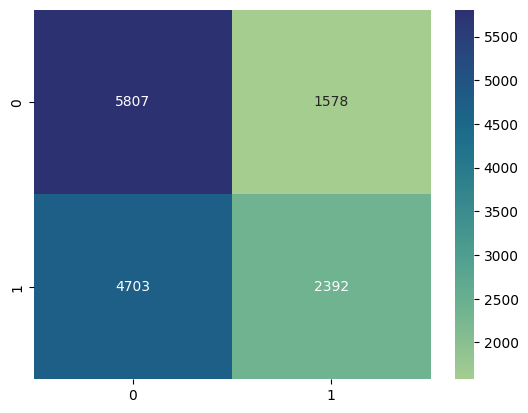

In [57]:
y_pred = model_tf.predict(x_valid)
metric_dict, cm = labeling_evaluating(y_valid, y_pred, threshold = 0.5)
sns.heatmap(cm, annot=True, cmap="crest", fmt='.4g')
print(metric_dict)

# 4 | Find and focus on the most predictive variables

In [31]:
feature_importance = model_xgb.feature_importances_
feature_names = x_train.columns

In [32]:
print(feature_importance.shape, feature_names.shape)

(226,) (226,)


In [33]:
fi_ser = pd.Series(feature_importance, index = feature_names).sort_values()

Text(0.5, 1.0, "Distribution of features' importance")

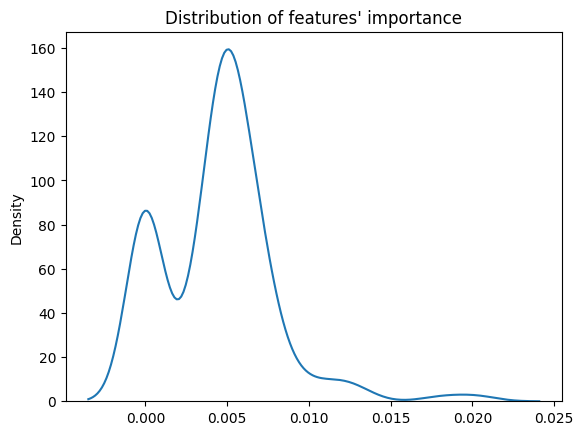

In [38]:
sns.kdeplot(fi_ser)
plt.gca().set_title("Distribution of features' importance")

> **Lets try to drop features with importance score less than 0.005 and train the model**

In [39]:
interested_features = fi_ser[fi_ser >= 0.005].index #interested ones are those having importance score of more than 0.005

In [40]:
interested_features

Index(['recv_vce_Mean', 'custcare_Mean', 'area_HOUSTON AREA', 'mou_rvce_Mean',
       'income', 'ethnic_N', 'marital_S', 'mou_opkd_Mean', 'threeway_Mean',
       'area_DALLAS AREA', 'drop_blk_Mean', 'ccrndmou_Mean', 'unan_dat_Mean',
       'comp_dat_Mean', 'comp_vce_Mean', 'area_GREAT LAKES AREA',
       'peak_vce_Mean', 'mou_cdat_Mean', 'ovrmou_Mean', 'crclscod_B2',
       'area_ATLANTIC SOUTH AREA', 'iwylis_vce_Mean', 'area_SOUTHWEST AREA',
       'crclscod_A', 'plcd_dat_Mean', 'opk_vce_Mean', 'crclscod_ZA',
       'dwllsize_O', 'plcd_vce_Mean', 'crclscod_DA', 'inonemin_Mean', 'adjqty',
       'ethnic_F', 'avg6mou', 'area_PHILADELPHIA AREA', 'crclscod_AA',
       'mouowylisv_Mean', 'rev_Mean', 'mou_opkv_Mean', 'mou_peav_Mean',
       'attempt_Mean', 'change_rev', 'kid0_2_U', 'models', 'kid16_17_U',
       'area_SOUTH FLORIDA AREA', 'avg3mou', 'adjrev', 'area_LOS ANGELES AREA',
       'avgrev', 'ethnic_J', 'mouiwylisv_Mean', 'adjmou', 'avg3qty',
       'ethnic_P', 'crclscod_C2', 'ownr

**Use new features to train model**

In [41]:
x_train_interested = x_train[interested_features]
x_valid_interested = x_valid[interested_features]

In [42]:
print(
    x_train_interested.shape,
    x_valid_interested.shape
)

(57916, 98) (14480, 98)


In [44]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(units = 150),
    tf.keras.layers.Dense(units = 100),
    tf.keras.layers.Dense(units = 50),
    tf.keras.layers.Dense(units = 20),
    tf.keras.layers.Dense(units = 1, activation='sigmoid'),
])

model_tf.compile(
    loss= 'BinaryCrossentropy',
    optimizer= 'Adam',
    metrics = ['accuracy']
)

In [47]:
model_tf.fit(
    x_train_interested,
    y_train,
    validation_data = (x_valid_interested, y_valid),
    epochs = 10
)

Epoch 1/10
1810/1810 [==============================] - 7s 4ms/step - loss: 0.6844 - accuracy: 0.5722 - val_loss: 0.6806 - val_accuracy: 0.5731
Epoch 2/10
1810/1810 [==============================] - 7s 4ms/step - loss: 0.6825 - accuracy: 0.5763 - val_loss: 0.6768 - val_accuracy: 0.5776
Epoch 3/10
1810/1810 [==============================] - 8s 4ms/step - loss: 0.6835 - accuracy: 0.5801 - val_loss: 0.6815 - val_accuracy: 0.5749
Epoch 4/10
1810/1810 [==============================] - 7s 4ms/step - loss: 0.6809 - accuracy: 0.5791 - val_loss: 0.6926 - val_accuracy: 0.5604
Epoch 5/10
1810/1810 [==============================] - 7s 4ms/step - loss: 0.6812 - accuracy: 0.5785 - val_loss: 0.6770 - val_accuracy: 0.5748
Epoch 6/10
1810/1810 [==============================] - 7s 4ms/step - loss: 0.6852 - accuracy: 0.5771 - val_loss: 0.6764 - val_accuracy: 0.5736
Epoch 7/10
1810/1810 [==============================] - 7s 4ms/step - loss: 0.6811 - accuracy: 0.5789 - val_loss: 0.6775 - val_accuracy:

453/453 [==============================] - 1s 2ms/step
{'accuracy': 0.5647099447513813, 'precision': 0.610738255033557, 'recall': 0.30782241014799155, 'F1': 0.40933370818105147}


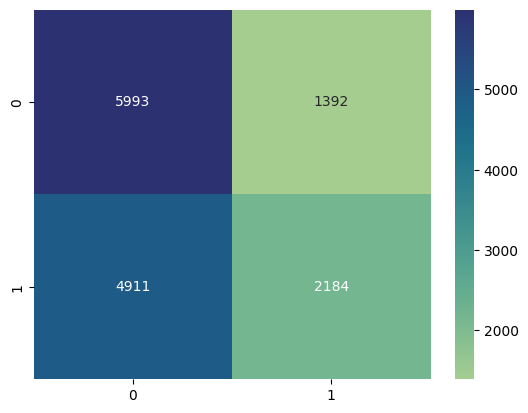

In [48]:
y_pred = model_tf.predict(x_valid_interested)
metric_dict, cm = labeling_evaluating(y_valid, y_pred, threshold = 0.5)
sns.heatmap(cm, annot=True, cmap="crest", fmt='.4g')
print(metric_dict)

In [50]:
model_xgb = XGBClassifier()

In [51]:
model_xgb.fit(x_train_interested, y_train, verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

{'accuracy': 0.6337707182320442, 'precision': 0.6295172015033247, 'recall': 0.6138125440451022, 'F1': 0.6215656890030686}


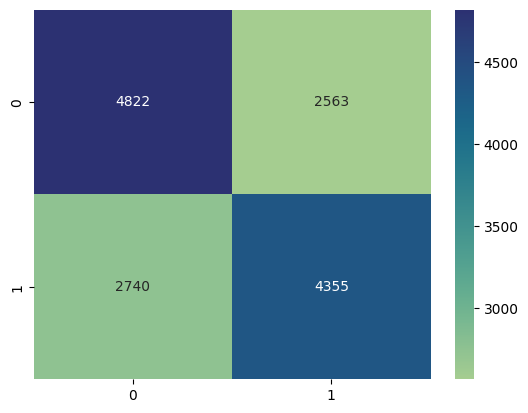

In [52]:
y_pred = model_xgb.predict(x_valid_interested)
metric_dict, cm = labeling_evaluating(y_valid, y_pred, threshold = 0.5)
sns.heatmap(cm, annot=True, cmap="crest", fmt='.4g')
print(metric_dict)

# 5 | Final Conclusion

### Result summary

**Before dropping unimportant features**

- XGB: accuracy of 0.63, f1 score of 0.62
- Neural Network: accuracy of 0.57, f1 score of 0.43

**After dropping unimportant features**

- XGB: accuracy of 0.63, f1 score of 0.62
- Neural Network: accuracy of 0.56, f1 score of 0.41

### Conclusion

- **XGB performed consistently** with an accuracy of 0.63 and an F1 score of 0.62 both before and after dropping unimportant features.
- **The Neural Network had lower accuracy and F1 scores**, decreasing from 0.57 and 0.43 before to 0.56 and 0.41 after the changes.
- **XGB outperformed the Neural Network** in both accuracy and F1 score in this comparison.